In [43]:
import numpy, torch, math, random
import matplotlib.pyplot as plt

# S-P-S Stone Paper Scissor

### 1. **Histogram_based_model**

In [77]:
# memory
games = 0
human = 0
computer = 0

# Initialize likelihood with equal probability for each move
bot_played = {"rock":0, "paper":0, "scissor":0}
hum_played = {"rock":0, "paper":0, "scissor":0}
likelihood = torch.Tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]])

In [78]:
# utility
code_to_move = {0: "rock", 1: "paper", 2: "scissor"}
move_to_code = {"rock": 0, "paper": 1, "scissor": 2}
player_to_code = {"bot": 0, "human": 1}
code_to_player = {0: "bot", 1: "human"}


@torch.no_grad()
def update(result, bot_dec, hum_dec):
    """
    Updates the likelihood matrix based on the result of the game.
    result: 0 (loss), 1 (win), -1 (tie)
    bot_dec: bot's move (0 = rock, 1 = paper, 2 = scissors)
    hum_dec: human's move (0 = rock, 1 = paper, 2 = scissors)
    """
    lr = 0.1 / (1 + games * 0.001)
    if result == 0:  # Bot wins
        likelihood[bot_dec, hum_dec] += likelihood[bot_dec, hum_dec] * lr
        likelihood[hum_dec, bot_dec] -= likelihood[hum_dec, bot_dec] * lr
    elif result == 1:  # Human wins
        likelihood[bot_dec, hum_dec] -= likelihood[bot_dec, hum_dec] * lr
        likelihood[hum_dec, bot_dec] += likelihood[hum_dec, bot_dec] * lr
    elif result == -1:  # Tie
        likelihood[bot_dec] += lr
        likelihood[hum_dec] += lr

    # Normalize the likelihood to maintain probabilities
    ll = likelihood / likelihood.sum(dim=1, keepdim=True)
    return ll


@torch.no_grad()
def think(dec):
    """
    Bot makes a decision based on the likelihood matrix.
    hum_dec: The human's last move (0 = rock, 1 = paper, 2 = scissors)
    """
    # Use the likelihood matrix to predict the player's next move
    next_move_probs = likelihood[dec]
    next_move = torch.multinomial(next_move_probs, 1).item()
    return next_move


who_win = [
    [-1, 1, 0],  # Rock vs (Rock, Paper, Scissors) -> (tie, loss, win)
    [0, -1, 1],  # Paper vs (Rock, Paper, Scissors) -> (win, tie, loss)
    [1, 0, -1],  # Scissors vs (Rock, Paper, Scissors) -> (loss, win, tie)
]

In [79]:
# game
print("Enter 0 for Rock, 1 for Paper, 2 for Scissors")
ix = 0
while True:
    try:
        bot = think(ix)
        hum = int(input("Your move (0 = Rock, 1 = Paper, 2 = Scissors): "))
        if hum not in [0, 1, 2]:
            print("Invalid input. Please enter 0, 1, or 2.")
            continue

        # Tracking
        bot_played[code_to_move[bot]] = bot_played.get(code_to_move[bot], 0) + 1
        hum_played[code_to_move[hum]] = hum_played.get(code_to_move[hum], 0) + 1

        result = who_win[bot][hum]
        print("You choosed: "+code_to_move[hum])
        if result == 0:
            print("You lose! Bot chose", code_to_move[bot])
            computer += 1
        elif result == 1:
            print("You win! Bot chose", code_to_move[bot])
            human += 1
        else:
            print("It's a tie! Bot chose", code_to_move[bot])

        likelihood = update(result, bot, hum)
        ix = hum
        games += 1
    except Exception as e:
        print("Error occurred. Exiting game.", e)
        break

Enter 0 for Rock, 1 for Paper, 2 for Scissors
You choosed: paper
You lose! Bot chose scissor
You choosed: scissor
You lose! Bot chose rock
You choosed: paper
You lose! Bot chose scissor
You choosed: paper
You lose! Bot chose scissor
You choosed: paper
You win! Bot chose rock
You choosed: paper
You win! Bot chose rock
You choosed: paper
It's a tie! Bot chose paper
You choosed: paper
You win! Bot chose rock
You choosed: paper
You lose! Bot chose scissor
You choosed: paper
It's a tie! Bot chose paper
You choosed: paper
You win! Bot chose rock
You choosed: paper
You win! Bot chose rock
You choosed: scissor
You lose! Bot chose rock
You choosed: rock
You win! Bot chose scissor
You choosed: rock
You win! Bot chose scissor
You choosed: rock
You win! Bot chose scissor
You choosed: paper
It's a tie! Bot chose paper
You choosed: scissor
You win! Bot chose paper
You choosed: paper
It's a tie! Bot chose paper
You choosed: rock
You win! Bot chose scissor
You choosed: paper
You lose! Bot chose scisso

In [80]:
# logs
print(f"Total games played: {games}")
print(f"Human score: {human}")
print(f"Bot score: {computer}")

Total games played: 41
Human score: 18
Bot score: 13


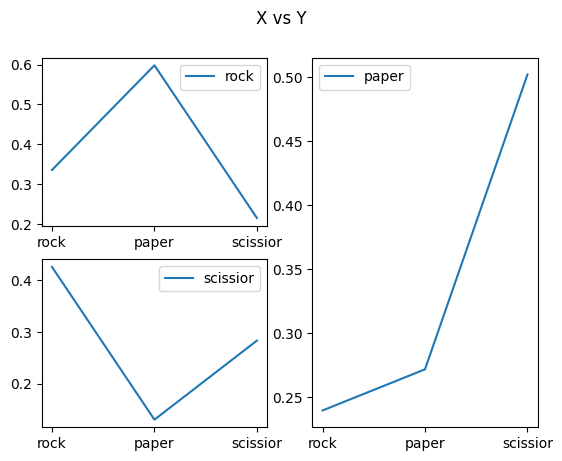

In [81]:
# analysing memory
x = likelihood
label = ["rock", "paper", "scissior"]
fig, axs = plt.subplot_mosaic([["rock", "paper"],["scissor", "paper"]])
fig.suptitle("X vs Y")
for index, ax in enumerate(axs.values()):
  ax.plot(label, x[:, index], label=label[index])
  ax.legend()

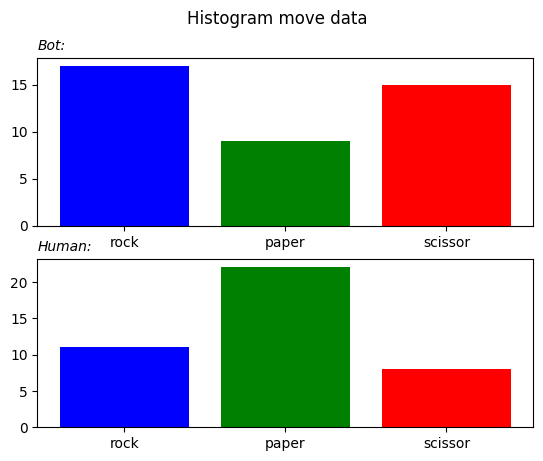

In [85]:
fig, axs = plt.subplot_mosaic([["t","t"],["b","b"]])
fig.suptitle("Histogram move data")
axs['t'].set_title('Bot:', loc='left', fontstyle='oblique', fontsize='medium')
axs["t"].bar(bot_played.keys(), bot_played.values(), color=['blue', 'green', 'red'])
axs['b'].set_title('Human:', loc='left', fontstyle='oblique', fontsize='medium')
axs["b"].bar(hum_played.keys(), hum_played.values(), color=['blue', 'green', 'red'])
plt.show()

### Conclusion

Based on the probabilistic model for Stone Paper Scissors, we can conclude that the more you play with the bot, the more difficult it becomes to win against it. This is due to the overfitting of data, where the bot continuously updates its likelihood matrix based on the outcomes of previous games. As a result, the bot is likely to choose the move that is most suitable to win against your previous move. This adaptive strategy allows the bot to improve its chances of winning over time, making it a more challenging opponent as the number of games increases.

> This model is based on the bigram model, where the next input is choosen based on the likely hood of the next gussed move.

The bot learns dynamically using a simple probabilistic model and improves its predictions based on the previous human move.

### 2. **MLP approach**

In [86]:
# initialization of weights
# -_________A.I memory_______-#
move_to_guess = 1
initial_guess = 0
total_moves = 3
n_hidden = 30

# -_________Game-analysis-memory_________-#
W1 = torch.nn.init.kaiming_normal_(
    torch.randn(total_moves, n_hidden), nonlinearity="tanh"
)
bais1 = torch.randn(1, n_hidden) * 0.01  # magical number
W2 = torch.randn(n_hidden, total_moves)/math.sqrt(n_hidden) # apply the kaiming fan_in only not the gain!
paramters = [W1, bais1, W2]
for p in paramters:
  p.requires_grad = True

In [88]:
# Game!
lossi = []
ix = initial_guess
while True:
  # forward pass
  # embed = C[[ix]]
  hpreact = W1[ix] + bais1
  h = hpreact.tanh()
  logits = h@W2
  loss = torch.nn.functional.cross_entropy(logits, torch.tensor([ix]))
  probs = torch.nn.functional.softmax(logits, 1)
  # Now main work!
  bot_guess = torch.multinomial(probs, num_samples=move_to_guess)
  human_showed = None

  signal_exit = False
  while True:
    try:
      human_showed = int(input("Enter(0.rock), (1.paper), (2.scissor): "))
      if human_showed > 3 and human_showed < 0:
        print("Ivalid!")
      else:
        break
    except Exception:
      signal_exit = True
      break;

  if signal_exit:
    break; 

  # rewarding_time (backward_pass)
  for p in paramters:
    p.grad = None
  loss.backward()

  ix = human_showed

  # if the guess is correct improve the probability!
  lr = 0.1 if human_showed == bot_guess[0,0] else -0.05

  # gradient clipping
  torch.nn.utils.clip_grad_norm_(parameters=paramters, max_norm=1.0)

  # update
  for p in paramters:
    p.data += -lr * p.grad

  lossi.append(loss.log10())
  print(f"bot_guess={bot_guess[0,0]}, {human_showed=}")
  # break

bot_guess=2, human_showed=1
bot_guess=0, human_showed=2
bot_guess=2, human_showed=0
bot_guess=2, human_showed=1
bot_guess=2, human_showed=2
bot_guess=1, human_showed=1
bot_guess=1, human_showed=0
bot_guess=2, human_showed=1
bot_guess=0, human_showed=2
bot_guess=0, human_showed=1
bot_guess=0, human_showed=0
bot_guess=2, human_showed=1
bot_guess=1, human_showed=2
bot_guess=0, human_showed=1


### version2 **MLP approach**

In [105]:
context_size = 10  # remember 10 move to accuire pattern
context = [0] * context_size
n_embed = 3
initial_guess = 0
move_to_guess = 1
total_moves = 3
n_hidden = 30

# -_________Game-analysis-memory_________-#
C = torch.randn(3, 3)
W1 = torch.nn.init.kaiming_normal_(
    torch.randn(context_size*n_embed, n_hidden), nonlinearity="tanh"
)
bais1 = torch.randn(1, n_hidden) * 0.01  # magical number
W2 = torch.randn(n_hidden, total_moves) / math.sqrt(
    n_hidden
)  # apply the kaiming fan_in only not the gain!
paramters = [C, W1, bais1, W2]
for p in paramters:
    p.requires_grad = True

In [111]:
# Game!
lossi = []
last_context = context[-1]
while True:
    # forward pass
    Xb = torch.tensor(context)
    hpreact = C[Xb].view(1, -1) @ W1 + bais1
    h = hpreact.tanh()
    logits = h @ W2
    loss = torch.nn.functional.cross_entropy(logits, torch.tensor([last_context]))
    probs = torch.nn.functional.softmax(logits, 1)
    # Now main work!
    bot_guess = torch.multinomial(probs, num_samples=move_to_guess)
    human_showed = None

    signal_exit = False
    while True:
        try:
            human_showed = int(input("Enter(0.rock), (1.paper), (2.scissor): "))
            if human_showed not in [0, 1, 2]:
                print("Ivalid!")
            else:
                break
        except Exception:
            print("Exiting...")
            signal_exit = True
            break
    if signal_exit:
        break

    # rewarding_time (backward_pass)
    for p in paramters:
        p.grad = None
    loss.backward()
    last_context = human_showed
    context = context[1:] + [last_context]

    print(context)

    # if the guess is correct improve the probability!
    # idk but it works!
    # revised version:
    # lr = 0.1 if who_win[bot_guess[0,0]][human_showed] == 0 else -0.05
    if bot_guess[0,0] == human_showed:
        # tie
        lr = 0.05
    elif who_win[bot_guess[0,0]][human_showed] == 0:
        # bot win
        lr = 0.1
    else:
        # human win
        lr = -0.05

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(parameters=paramters, max_norm=1.0)

    # update
    for p in paramters:
        p.data += -lr * p.grad

    lossi.append(loss.log10())
    print(f"bot_guess={bot_guess[0,0]}, {human_showed=}")
    winner = "tie"
    if who_win[bot_guess[0,0]][human_showed] == 0:
        winner = "bot"
    elif who_win[bot_guess[0,0]][human_showed] == 1:
        winner = "human"
    print(f"winner is {winner}")
print("Thanku for playing this game.")

[1, 1, 1, 0, 2, 1, 0, 0, 1, 1]
bot_guess=2, human_showed=1
winner is bot
[1, 1, 0, 2, 1, 0, 0, 1, 1, 2]
bot_guess=2, human_showed=2
winner is tie
[1, 0, 2, 1, 0, 0, 1, 1, 2, 0]
bot_guess=2, human_showed=0
winner is human
[0, 2, 1, 0, 0, 1, 1, 2, 0, 1]
bot_guess=2, human_showed=1
winner is bot
[2, 1, 0, 0, 1, 1, 2, 0, 1, 0]
bot_guess=0, human_showed=0
winner is tie
[1, 0, 0, 1, 1, 2, 0, 1, 0, 1]
bot_guess=2, human_showed=1
winner is bot
[0, 0, 1, 1, 2, 0, 1, 0, 1, 0]
bot_guess=0, human_showed=0
winner is tie
[0, 1, 1, 2, 0, 1, 0, 1, 0, 2]
bot_guess=2, human_showed=2
winner is tie
Exiting...
Thanku for playing this game.
